
You've just been hired by Esoteric 24hr Fitness as their first data
scientist.  Your first task is to analyze a data set they collected.
The data covers a period from Jan 1st 2011 to mid-March 2011, and
contains information about what exercises people did in that
period. The data takes the format:
```
  time,user_id,exercise_code
  2011-01-02T08:43:00,194,strength4
  2011-01-02T08:49:00,258,strength4
  2011-01-02T09:02:00,194,strength2
  2011-01-02T09:08:30,296,cardio3
  2011-01-02T09:18:00,258,cardio1
```
where `time` is a timestamp that shows when an exercise *began* (we
don't know when the exercise ended), the userid is an integer that
corresponds to a gym member, and exercise_code is a label that shows
what exercise it is. No one is sure exactly which exercise a code
corresponds to (other than the strength and cardio distinction).
Using this data, see if you can answer the following questions:
  - Explore when the gym tends to be used most and least.  The
    machines need to be cleaned for ~2 hours once a week, and going
    forward the gym will shut down for those 2 hours (so in the
    future, the gym will be open only 166 hours per week).  What
    2-hour window should the gym choose for cleaning and maintenance,
    so as to be minimally disruptive to users?
  - The gym might want to replace the least popular machine.  What is
    the least popular exercise?  How confident are you that this
    answer is robust?
  - How long do members spend doing the individual exercises? (This
    will be used to help trainers plan time-efficient routines.)
    The personal trainers think that some members in this study were
    doing some exercises too quickly and had bad form. Can we identify
    which members these were, to target them for personal training
    advice?
  - The personal trainers also have the idea that some people tend to
    stick to certain exercises.  Can we find groups of exercises that
    tend to cluster together in the user base?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
from scipy.stats import norm, beta

plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

In [2]:
exercise = pd.read_csv('example_data.csv')
exercise['time'] = pd.to_datetime(exercise['time'])

In [3]:
exercise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35180 entries, 0 to 35179
Data columns (total 3 columns):
time             35180 non-null datetime64[ns]
user_id          35180 non-null int64
exercise_code    35180 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 824.6+ KB


In [4]:
max(exercise.time) - min(exercise.time)

Timedelta('72 days 22:39:30')

Note this is not a full number of weeks. This will bias the results in pure count for the extra two days. We could take an average for each week, but it is a little simpler to truncate the extra two days and deal with 10 full weeks.

In [5]:
max(exercise.time)

Timestamp('2011-03-15 00:15:00')

In [6]:
max(exercise.time) - dt.timedelta(days=70)

Timestamp('2011-01-04 00:15:00')

In [7]:
exercise.head()

,time,user_id,exercise_code
0,2011-01-01 01:35:30,334,strength5
1,2011-01-01 01:39:00,94,strength2
2,2011-01-01 01:51:00,94,strength1
3,2011-01-01 02:04:30,166,cardio4
4,2011-01-01 02:06:30,334,cardio4


In [8]:
exercise = exercise[exercise.time >= '2011-01-04']

In [9]:
min(exercise.time)

Timestamp('2011-01-04 00:13:30')

In [10]:
exercise['hour'] = exercise.time.dt.dayofweek*24 + exercise.time.dt.hour

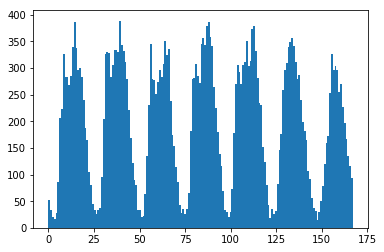

In [11]:
plt.hist(exercise.hour, bins=168);

In [12]:
exercise['day'] = exercise['hour'] // 24

In [13]:
exercise['day_hour'] = exercise['hour'].apply(lambda x: (x // 24, x % 24))

In [14]:
exercise['day_hour'].value_counts().tail(n=30)

(5, 1)    42
(3, 0)    42
(1, 4)    38
(6, 2)    37
(3, 4)    36
(3, 2)    35
(5, 3)    35
(2, 1)    34
(4, 1)    33
(1, 1)    33
(0, 1)    33
(2, 2)    33
(1, 3)    33
(6, 3)    31
(5, 5)    31
(4, 2)    30
(6, 5)    30
(4, 4)    30
(3, 1)    27
(0, 4)    27
(5, 4)    26
(1, 2)    26
(3, 3)    26
(2, 4)    22
(2, 3)    21
(0, 2)    21
(4, 3)    20
(5, 2)    19
(0, 3)    17
(6, 4)    14
Name: day_hour, dtype: int64

It seems pretty consistent that the early morning is the slowest. Since we need a couple of consecutive hours to clean the machines, the Tuesday 3am -- 5am slot looks the most promising, but most days 2 -- 5 am look quiet.

Let's see this visualized as a heatmap

In [15]:
exercise['hour_of_day'] = exercise.hour % 24
exercise_day_hour_table = exercise.groupby(['day', 'hour_of_day'])['time'].count().reset_index().rename(columns={'time': 'num_exercise'})
exercise_day_hour_table.head()

,day,hour_of_day,num_exercise
0,0,0,52
1,0,1,33
2,0,2,21
3,0,3,17
4,0,4,27


In [16]:
exercise_day_hour_map = exercise_day_hour_table.pivot_table(index = 'hour_of_day', columns = 'day', values='num_exercise').fillna(0)

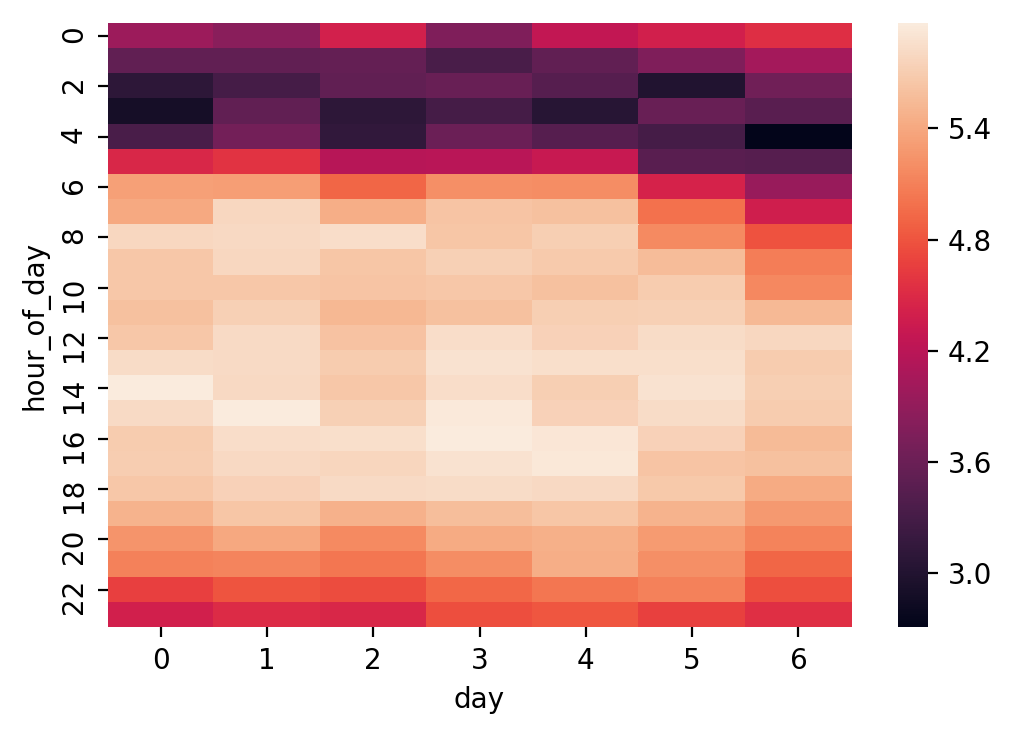

In [17]:
# Take the log so we get more fidelity in the low usage time period.
plt.figure(dpi=200)
sns.heatmap(np.log1p(exercise_day_hour_map));

# Least popular machine

In [18]:
exercise.exercise_code.value_counts()

strength1    4894
cardio3      4760
cardio2      4378
cardio4      3617
cardio5      3366
cardio1      3183
strength2    3041
strength3    2513
strength4    2056
strength5    2027
Name: exercise_code, dtype: int64

Note there is only a small difference in the last two exercises. Probably worth comparing if the count is actually different.

Let's look at a week by week breakdown. First let's see if we can use `dt.week`

In [19]:
exercise.groupby([exercise.time.dt.week])['day'].nunique()

time
1     6
2     7
3     7
4     7
5     7
6     7
7     7
8     7
9     7
10    7
11    2
Name: day, dtype: int64

Ok, even though we have 10 full weeks, we need to make our own week count

In [20]:
exercise['week'] = (exercise.time - min(exercise.time)).dt.days // 7

In [21]:
count_exercises = exercise.groupby([exercise.week, exercise.exercise_code]).count()['hour'].reset_index()
count_exercises.rename(columns={'hour': 'count_exercise'}, inplace=True)
count_exercises.head()

,week,exercise_code,count_exercise
0,0,cardio1,315
1,0,cardio2,437
2,0,cardio3,499
3,0,cardio4,347
4,0,cardio5,354


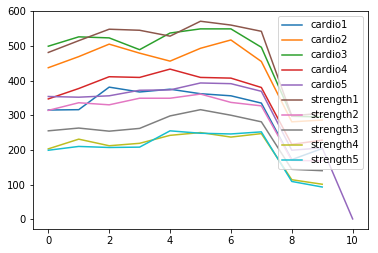

In [22]:
for gp_name, gp in count_exercises.groupby('exercise_code'):
    plt.plot(gp.week, gp.count_exercise, label=gp_name)
plt.legend();

Note there is some strange dropoff around week 7. 

Some ideas:

* Poisson test? It seems that $\lambda$ is slowly increasing before week 7, then sharply decreases after that.
* GLM/regression? If applied up to week 7, this has some promise, but will fail in that dip. Won't be generalizable to non-linear patterns.
* Treat counts as normally distributed around some mean, test for difference in counts?
* Treat proportions as binomial variable and test for significant difference in proportions.

The last two would be done as Hypothesis tests amongst the strength4 and strength5. It would be nice to do an FDR style analysis, or a Multinomial test instead.

Let's look at the difference between the lowest two exercises

In [23]:
count_exercises.head()

,week,exercise_code,count_exercise
0,0,cardio1,315
1,0,cardio2,437
2,0,cardio3,499
3,0,cardio4,347
4,0,cardio5,354


In [24]:
count_exercise_table = count_exercises.pivot(index = 'week', columns='exercise_code', values='count_exercise')

In [25]:
count_exercise_table

exercise_code,cardio1,cardio2,cardio3,cardio4,cardio5,strength1,strength2,strength3,strength4,strength5
week,,,,,,,,,,
0,315.0,437.0,499.0,347.0,354.0,481.0,314.0,255.0,203.0,199.0
1,316.0,469.0,526.0,377.0,352.0,515.0,336.0,263.0,231.0,210.0
2,381.0,505.0,523.0,411.0,356.0,548.0,330.0,254.0,212.0,207.0
3,367.0,479.0,489.0,409.0,372.0,545.0,349.0,262.0,219.0,208.0
4,375.0,456.0,537.0,433.0,373.0,528.0,349.0,298.0,242.0,255.0
5,362.0,493.0,549.0,409.0,393.0,571.0,361.0,316.0,250.0,248.0
6,356.0,517.0,549.0,407.0,391.0,560.0,337.0,300.0,237.0,246.0
7,335.0,455.0,496.0,380.0,369.0,542.0,327.0,281.0,247.0,252.0
8,172.0,281.0,297.0,216.0,199.0,298.0,170.0,144.0,114.0,109.0


## Difference in counts as a normal dist?

In [26]:
count_exercise_table.loc[:8].describe()

exercise_code,cardio1,cardio2,cardio3,cardio4,cardio5,strength1,strength2,strength3,strength4,strength5
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,331.000000,454.666667,496.111111,376.555556,351.000000,509.777778,319.222222,263.666667,217.222222,214.888889
std,64.319515,69.964277,77.931772,65.257396,58.898217,83.701520,57.649323,50.037486,41.898024,45.619197
min,172.000000,281.000000,297.000000,216.000000,199.000000,298.000000,170.000000,144.000000,114.000000,109.000000
25%,316.000000,455.000000,496.000000,377.000000,354.000000,515.000000,327.000000,255.000000,212.000000,207.000000
50%,356.000000,469.000000,523.000000,407.000000,369.000000,542.000000,336.000000,263.000000,231.000000,210.000000
75%,367.000000,493.000000,537.000000,409.000000,373.000000,548.000000,349.000000,298.000000,242.000000,248.000000
max,381.000000,517.000000,549.000000,433.000000,393.000000,571.000000,361.000000,316.000000,250.000000,255.000000


Note that I don't want to use the standard deviation posted here, as there is a linear trend that will artificially inflate the stddev

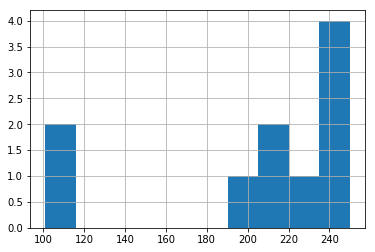

In [27]:
count_exercise_table['strength4'].hist()

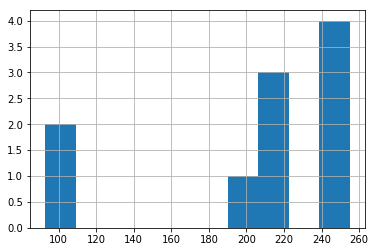

In [28]:
count_exercise_table['strength5'].hist()

Neither count is normally distributed.

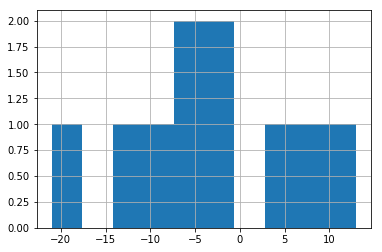

In [29]:
(count_exercise_table['strength5'] - count_exercise_table['strength4']).hist()

Let's look at the sequences of differences:

We could do some normality tests (such as skew or kurtosis tests) but with so few data points they are likely to be underpowered. There also are not quite enough values to apply the CLT, but the distribution doesn't look very funky.

In [30]:
diff = (count_exercise_table['strength5'] - count_exercise_table['strength4'])
diff.mean(), diff.std()

(-2.9, 9.926955446885236)

Test if `diff` is normally distributed, can we reject the hypothesis that the mean is zero?

In [31]:
z_score = (diff.mean() - 0)/(diff.std()/np.sqrt(len(diff)))
z_score

-0.9688984647401182

What is the (one-sided) p value?

In [32]:
# note our z-score is negative, and we are measuring two-tailedness here
2*norm(0, 1).cdf(z_score)

0.33259585154992743

The answer is not particularly significant: there is a 42% chance that we could see a result this large if the difference in means were exactly the same.

What is the size of the interval?

In [33]:
std_error = diff.std()/np.sqrt(len(diff))
z_crit = norm().ppf(0.975)
diff.mean() - z_crit*std_error, diff.mean() + z_crit*std_error

(-8.766347983832045, 2.9663479838320455)

## Same question, but now as proportions

This model assumes that $N$ exercises are going to be done, but asks how they are split between the different exercise routines. Techically, this is a multinomial distribution; I will simplify it by treating the last two pieces as part of a binomial distribution and asking if the rates are signficantly different.

In [34]:
exercise['exercise_code'].value_counts(normalize=True)

strength1    0.144643
cardio3      0.140683
cardio2      0.129393
cardio4      0.106901
cardio5      0.099483
cardio1      0.094074
strength2    0.089877
strength3    0.074272
strength4    0.060765
strength5    0.059908
Name: exercise_code, dtype: float64

In [35]:
# Find 95% CI
N = exercise.shape[0]
N

33835

In [36]:
def get_CI(p, N, width = 0.95):
    alpha = 1-width
    lower, upper = alpha/2, width + alpha/2
    return beta(a=p*N, b=(1-p)*N).ppf([lower, upper])

In [37]:
get_CI(0.06, N)

array([0.05749429, 0.06255498])

We can easily see the proportion difference will not be significant, this doesn't give us a numerical "non-robustness". Let's do the p-value thing, and see how it compares to the previous result.

In [38]:
exercise_props = exercise['exercise_code'].value_counts(normalize=True)
delta_p = exercise_props['strength4'] - exercise_props['strength5']
pooled = exercise_props['strength4'] + exercise_props['strength5']
std_error = np.sqrt(2*pooled*(1-pooled)/N)

z_score_prop = delta_p/std_error

In [39]:
z_score_prop

0.34223018956593726

In [40]:
# Here the z-score is positive
2*(1 - norm.cdf(z_score_prop))

0.7321776674114613

There is a 73% chance of getting a difference this extreme or more for the proportions.

We can also do an actual simulation from the beta distributions

In [41]:
exercise_count = exercise['exercise_code'].value_counts()
s4_beta = beta(a=exercise_count['strength4'],b = N - exercise_count['strength4'] )
s5_beta = beta(a=exercise_count['strength5'],b = N - exercise_count['strength5'])

num_sims = 1000000
times_greater = sum(s5_beta.rvs(num_sims) > s4_beta.rvs(num_sims))
        
print(times_greater / num_sims)

0.320667


i.e. from the $\beta$ distributions (__not__ the null hypothesis) we would see the results reversed approximately 32% of the time.

## How would I treat the rates as multinomial?

In [42]:
from scipy.stats import multinomial, dirichlet

In [43]:
observed = multinomial(N, exercise_props)

Under the asssumption that the observed values are the correct ones, let us determine how frequently the "least likely" exercise is to be at the bottom of the list

In [44]:
num_sim = 10000
lowest_index = len(exercise_props) - 1
sum(np.argsort(observed.rvs(size=num_sim))[:, 0] == lowest_index) / num_sim

0.6675

i.e. even assuming there was a difference, we would only expect the least popular exercise (`strength5`) to appear at the bottom of the list 67% of the time.

In [45]:
exercise_props

strength1    0.144643
cardio3      0.140683
cardio2      0.129393
cardio4      0.106901
cardio5      0.099483
cardio1      0.094074
strength2    0.089877
strength3    0.074272
strength4    0.060765
strength5    0.059908
Name: exercise_code, dtype: float64

## How long did people spend doing exercises?

This seems like a hard problem, as we have no ending times. 

**Assumption**

The assumption should be the people spend at most 3 hours on any one exercise. Longer than that and we assume they left the gym and came back. This will define "sessions" that people spend at the gym. 

We will also assume people go from one exercise to the next, so we can use the starting time between exercises as the duration they spent on that exercise; unless it is the last exercise in a session (which is unknowable).

In [46]:
# How many gym users are there?
exercise.user_id.nunique()

350

In [47]:
exercise = exercise.sort_values('time')
exercise['time_since'] = -exercise.groupby('user_id')['time'].diff(periods=-1)

In [48]:
# spot check 
exercise[exercise['user_id']==284]

,time,user_id,exercise_code,hour,day,day_hour,hour_of_day,week,time_since
1345,2011-01-04 00:13:30,284,strength2,24,1,"(1, 0)",0,0,0 days 00:07:00
1346,2011-01-04 00:20:30,284,strength3,24,1,"(1, 0)",0,0,0 days 00:18:00
1347,2011-01-04 00:38:30,284,strength1,24,1,"(1, 0)",0,0,0 days 01:18:00
1348,2011-01-04 01:56:30,284,cardio3,25,1,"(1, 1)",1,0,0 days 13:08:00
1660,2011-01-04 15:04:30,284,strength5,39,1,"(1, 15)",15,0,0 days 00:06:00
1665,2011-01-04 15:10:30,284,strength3,39,1,"(1, 15)",15,0,0 days 01:43:00
1724,2011-01-04 16:53:30,284,cardio3,40,1,"(1, 16)",16,0,1 days 21:11:30
2687,2011-01-06 14:05:00,284,strength3,86,3,"(3, 14)",14,0,0 days 00:59:00
2723,2011-01-06 15:04:00,284,cardio4,87,3,"(3, 15)",15,0,0 days 00:19:00
2738,2011-01-06 15:23:00,284,strength1,87,3,"(3, 15)",15,0,0 days 00:23:00


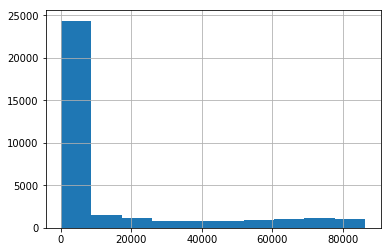

In [49]:
# Look at the distribution (before cutting)

exercise.time_since.dt.seconds.hist()

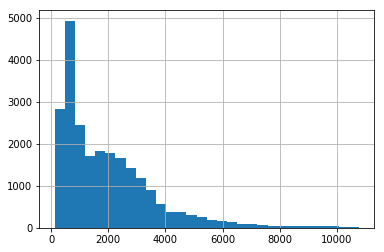

In [50]:
MAX_SESSION_LENGTH = 3 * 60 * 60
exercise.dropna(inplace=True)
exercise_sessions_mask = exercise.time_since.dt.total_seconds() < MAX_SESSION_LENGTH
exercise.loc[exercise_sessions_mask, 'time_since'].dt.seconds.hist(bins=30)

Okay, this list seems reasonable. We may even be able to cut at the two hour mark instead.


Let's find out what each members _median_ time was on each routine, so we are not skewed by outliers

In [51]:
time_spent = (exercise[exercise_sessions_mask].groupby(['user_id', 'exercise_code'])
                                              .apply(lambda x:x['time_since'].dt.seconds.median())
                                              .reset_index()
                                              .rename(columns={0: 'median_time'})
             )

In [52]:
time_spent.head()

,user_id,exercise_code,median_time
0,0,cardio1,2880.0
1,0,cardio2,3360.0
2,0,cardio3,3180.0
3,0,cardio4,4050.0
4,0,strength1,3030.0


In [53]:
# now let's get the median time for each exercise_code
median_times = exercise[exercise_sessions_mask].groupby('exercise_code')['time_since'].apply(lambda x: x.dt.seconds.median())
iqr_times = exercise[exercise_sessions_mask].groupby('exercise_code')['time_since'].apply(lambda x: x.dt.seconds.quantile(0.75) - x.dt.seconds.quantile(0.25))
decile_times = exercise[exercise_sessions_mask].groupby('exercise_code')['time_since'].apply(lambda x: x.dt.seconds.quantile(0.10))

In [54]:
exercise[exercise_sessions_mask].groupby('exercise_code').describe().T.xs(level=0, key='time_since')

exercise_code,cardio1,cardio2,cardio3,cardio4,cardio5,strength1,strength2,strength3,strength4,strength5
count,1767,3416,2187,2206,884,4615,2696,2419,1707,1771
mean,0 days 00:37:12.224108,0 days 00:34:27.953747,0 days 00:39:39.094650,0 days 00:33:04.542157,0 days 00:40:36.957013,0 days 00:32:52.862405,0 days 00:28:36.409495,0 days 00:32:45.651095,0 days 00:25:25.817223,0 days 00:25:17.583286
std,0 days 00:30:57.595067,0 days 00:31:04.965914,0 days 00:35:02.184852,0 days 00:28:31.438997,0 days 00:40:40.316271,0 days 00:23:29.854097,0 days 00:24:03.477588,0 days 00:26:23.492419,0 days 00:24:52.050355,0 days 00:24:33.616378
min,0 days 00:02:00,0 days 00:02:00,0 days 00:02:00,0 days 00:02:00,0 days 00:02:00,0 days 00:02:00,0 days 00:02:00,0 days 00:05:00,0 days 00:02:00,0 days 00:02:00
25%,0 days 00:12:00,0 days 00:10:00,0 days 00:12:00,0 days 00:11:00,0 days 00:18:00,0 days 00:14:00,0 days 00:10:00,0 days 00:12:00,0 days 00:09:00,0 days 00:09:00
50%,0 days 00:32:00,0 days 00:21:00,0 days 00:30:00,0 days 00:27:30,0 days 00:28:00,0 days 00:30:00,0 days 00:22:00,0 days 00:23:00,0 days 00:15:00,0 days 00:15:00
75%,0 days 00:48:00,0 days 00:54:00,0 days 00:51:00,0 days 00:45:00,0 days 00:44:00,0 days 00:46:00,0 days 00:41:00,0 days 00:47:00,0 days 00:37:00,0 days 00:36:00
max,0 days 02:59:30,0 days 02:57:30,0 days 02:57:00,0 days 02:58:00,0 days 02:59:00,0 days 02:57:30,0 days 02:57:00,0 days 02:57:30,0 days 02:50:30,0 days 02:56:00


In [55]:
time_spend_overall = time_spent.merge(decile_times, left_on='exercise_code', right_index=True).rename(columns={'time_since':'10_percentile'})

In [56]:
id_users = time_spend_overall[time_spend_overall['median_time'] < time_spend_overall['10_percentile']]

In [57]:
id_users

,user_id,exercise_code,median_time,10_percentile
370,56,cardio1,420.0,480.0
551,82,cardio1,300.0,480.0
1336,198,cardio1,240.0,480.0
1888,284,cardio1,360.0,480.0
1970,295,cardio1,180.0,480.0
2320,347,cardio1,210.0,480.0
2018,302,cardio2,300.0,360.0
60,8,cardio4,450.0,480.0
184,28,cardio4,420.0,480.0
1072,158,cardio4,420.0,480.0


Let's make the information a little more visually appealing. Here we have the time in median time (in seconds) that 
this user spends on that exercise.

In [58]:
id_users.pivot_table(index = 'user_id', columns='exercise_code', values='median_time').fillna('')

exercise_code,cardio1,cardio2,cardio4,cardio5,strength1,strength2,strength3,strength4
user_id,,,,,,,,
1,,,,,,,480,
8,,,450,,,,,
13,,,,,,,,240
21,,,,,,,480,
28,,,420,,,,,
43,,,,,,,,180
54,,,,,300,,,
56,420,,,,,,,
77,,,,,,,510,


## Exercise clustering

We are looking for exercises that tend to be clustered by user. Let's approach this the following way:

* Look at the overall usage by user for any exercise. Cutoff some low frequency users, as they will likely be noisy.
* For the remaining users, calculate the percentage of the time they use each of the exercises. This will give us a 10 dimensional space
* Find clusters in that space


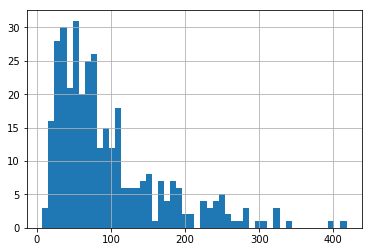

In [59]:
exercise['user_id'].value_counts().hist(bins=50)

What fraction of users have fewer than 30 exercises?

In [60]:
np.sum(exercise['user_id'].value_counts().values < 30) / exercise['user_id'].nunique()

0.11428571428571428

In [61]:
np.percentile(exercise['user_id'], [8.3, 10, 11])

array([31., 34., 38.])

In [62]:
np.sum(exercise['user_id'].value_counts() < 30)/350

0.11428571428571428

In [63]:
exercise['ones'] = 1
user_exercise = exercise.pivot_table(index='user_id', columns='exercise_code', values='ones', aggfunc=sum, fill_value=0)

In [64]:
user_exercise.head()

exercise_code,cardio1,cardio2,cardio3,cardio4,cardio5,strength1,strength2,strength3,strength4,strength5
user_id,,,,,,,,,,
0,9,1,12,13,0,8,4,0,0,0
1,7,13,14,13,12,45,44,44,42,37
2,5,19,8,2,2,17,2,4,4,3
3,0,21,25,1,11,0,0,6,0,0
4,4,3,2,2,3,16,18,16,23,19


In [65]:
# Here is a different way of doing the same thing
user_exercise_alt = (exercise[['user_id']].merge(pd.get_dummies(exercise['exercise_code']), 
                                                 left_index=True, right_index=True)
                                          .groupby('user_id')
                                          .sum(axis=1)
                    )
user_exercise_alt.head()

,cardio1,cardio2,cardio3,cardio4,cardio5,strength1,strength2,strength3,strength4,strength5
user_id,,,,,,,,,,
0,9,1,12,13,0,8,4,0,0,0
1,7,13,14,13,12,45,44,44,42,37
2,5,19,8,2,2,17,2,4,4,3
3,0,21,25,1,11,0,0,6,0,0
4,4,3,2,2,3,16,18,16,23,19


In [66]:
LOWER_CUTOFF = 30
user_mask = (user_exercise.sum(axis=1) > LOWER_CUTOFF)
user_exercise_prop = user_exercise.apply(lambda x: x/x.sum(), axis=1)

In [67]:
active_user_props = user_exercise_prop[user_mask]

In [68]:
from sklearn.cluster import KMeans

In [69]:
inertia = [KMeans(n_clusters=n_clusters).fit(user_exercise_prop).inertia_ for n_clusters in range(2,10)]

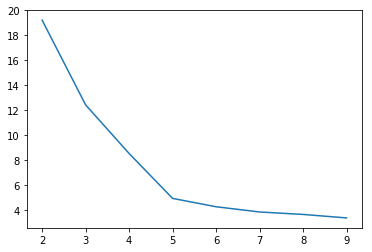

In [70]:
plt.plot(list(range(2,10)), inertia)

In [71]:
# It seems that 5 clusters have been identified

In [72]:
km = KMeans(n_clusters=5, random_state=41).fit(user_exercise_prop)

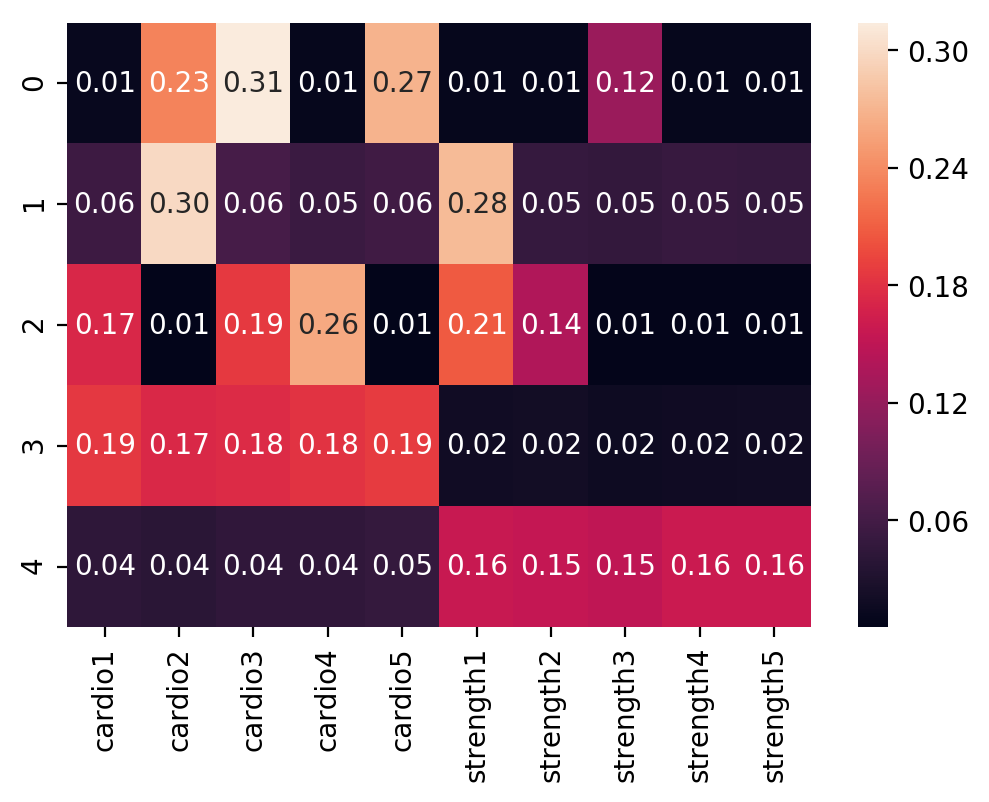

In [73]:
plt.figure(dpi=200)
sns.heatmap(km.cluster_centers_, xticklabels=user_exercise_prop.columns, annot=True, fmt='0.2f')

Very roughly, we have

* Cluster 0: Cardio2, Cardio3, Cartio5 with some Strength3
* Cluster 1: Cardio2 with Strength1
* Cluster 2: Mixed bag -- Cardio1, 3, 4 with Strength1 (And some strength2)
* Cluster 3: Cardio (all)
* Cluster 4: Strength (all)

Let's look at the number of users in each cluster

In [74]:
counts = [np.sum(km.labels_ == c) for c in range(km.n_clusters)]

In [75]:
counts

[74, 66, 82, 71, 57]

There is no cluster that is particularly small or just containing noise

Another question is whether any particular cluster has high inertia. There isn't really an inbuilt way of calculating this, so we just calculate directly

In [76]:
mask = (km.labels_ == 0)
np.sum((user_exercise_prop.loc[mask, :] - km.cluster_centers_[0])**2,axis=1).mean()

0.016770873904912043

In [77]:
def cluster_variance(km_object, X):
    variances = []
    for cluster_num in range(km_object.n_clusters):
        mask = (km_object.labels_ == cluster_num)
        distances = X.loc[mask, :] - km_object.cluster_centers_[cluster_num]
        variance = np.sum(distances**2, axis=1).mean()
        variances.append(variance)
    return variances

def RMS_from_center(km_object, X):
    return np.sqrt(cluster_variance(km_object, X))

In [78]:
RMS_from_center(km, user_exercise_prop)

array([0.12950241, 0.14412449, 0.1127471 , 0.11616937, 0.0747328 ])

This shows that all there isn't a particularly diffuse cluster (or that the least tightly clustered cluster is cluster 1)

In a similar vein, we can use silhoutte score:

In [79]:
from sklearn.metrics import silhouette_score

silhouette_score(user_exercise_prop, km.labels_)

0.5888140001229595

This tells us that if we average the silhoutte scores for each point, we get 0.5888, where

* An individual points silhoutte score tells us the normalized difference between the average distances between that point and points in the next nearest cluster and that point and points in its own cluster. 


## Alternative: association rule analysis

I probably wouldn't do this for an interview, but it is interesting to look at a more direct approach.

In [80]:
from mlxtend.frequent_patterns import apriori, association_rules

In [81]:
# prune any item < 5%, then promote any other item to 1
active_user_itemset = (active_user_props > 0.05).astype(int)

In [82]:
frequent_itemsets = apriori(active_user_itemset, min_support=0.07, use_colnames=True)

In [83]:
frequent_itemsets.sort_values('support', ascending=False)

,support,itemsets
2,0.834416,(cardio3)
1,0.642857,(cardio2)
5,0.623377,(strength1)
0,0.610390,(cardio1)
3,0.610390,(cardio4)
4,0.603896,(cardio5)
19,0.571429,"(cardio3, cardio2)"
11,0.568182,"(cardio1, cardio3)"
21,0.545455,"(cardio2, cardio5)"
27,0.542208,"(cardio3, cardio4)"


In [84]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head(n=29)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(cardio1),(cardio3),0.610390,0.834416,0.568182,0.930851,1.115572,0.058863,2.394605
1,(cardio3),(cardio1),0.834416,0.610390,0.568182,0.680934,1.115572,0.058863,1.221096
2,(cardio1),(cardio4),0.610390,0.610390,0.519481,0.851064,1.394296,0.146905,2.615955
3,(cardio4),(cardio1),0.610390,0.610390,0.519481,0.851064,1.394296,0.146905,2.615955
4,(cardio1),(strength1),0.610390,0.623377,0.425325,0.696809,1.117797,0.044822,1.242196
5,(strength1),(cardio1),0.623377,0.610390,0.425325,0.682292,1.117797,0.044822,1.226315
6,(cardio1),(strength2),0.610390,0.535714,0.389610,0.638298,1.191489,0.062616,1.283613
7,(strength2),(cardio1),0.535714,0.610390,0.389610,0.727273,1.191489,0.062616,1.428571
8,(cardio3),(cardio2),0.834416,0.642857,0.571429,0.684825,1.065283,0.035019,1.133157
9,(cardio2),(cardio3),0.642857,0.834416,0.571429,0.888889,1.065283,0.035019,1.490260


In [85]:
rules_with_cut = rules[(rules.lift > 3) & (rules.confidence > 0.8)].sort_values('lift')
rules_with_cut

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2418,"(strength4, strength2, strength3)",(strength5),0.237013,0.314935,0.224026,0.945205,3.001271,0.149382,12.502435
6639,"(strength4, cardio4, strength5)","(strength2, strength3)",0.120130,0.269481,0.097403,0.810811,3.008792,0.065030,3.861317
6667,"(strength4, strength1, cardio5)","(strength2, strength3)",0.155844,0.269481,0.126623,0.812500,3.015060,0.084626,3.896104
10060,"(cardio3, strength1, strength5, cardio5)","(strength2, strength3)",0.103896,0.269481,0.084416,0.812500,3.015060,0.056418,3.896104
10457,"(strength2, strength3, strength5, cardio4)","(strength4, strength1)",0.110390,0.292208,0.097403,0.882353,3.019608,0.065146,6.016234
6794,"(strength2, strength1, strength3, strength5)",(strength4),0.237013,0.308442,0.220779,0.931507,3.020043,0.147675,10.096753
6202,"(strength2, cardio3, strength5)","(strength1, strength3)",0.142857,0.285714,0.123377,0.863636,3.022727,0.082560,5.238095
2421,"(strength2, strength3, strength5)",(strength4),0.240260,0.308442,0.224026,0.932432,3.023044,0.149920,10.235065
9336,"(cardio1, strength2, strength3, strength5)","(strength4, strength1)",0.113636,0.292208,0.100649,0.885714,3.031111,0.067444,6.193182
6666,"(strength4, strength2, cardio5)","(strength1, strength3)",0.146104,0.285714,0.126623,0.866667,3.033333,0.084879,5.357143


Notes:

Let $\sigma(X)$ be the number of sets in our example that have $X$ as a subset.

| Quantity  | Definition |
| --- | --- |
| Support of a set X, $s(X)$: | $\sigma(X)/N$ |
| Support of a rule $X\rightarrow Y$ | support of $X \bigcup Y$ |
| Confidence in a rule $X \rightarrow Y$ | $\sigma(X \bigcup Y) / \sigma(X)$  |
| Lift of $X\rightarrow Y$| $c(X\rightarrow Y)/s(Y)$ |

The way these answers are interpreted is
>People who do "antecendents" are likely to do "consequents" with a rate of "lift - 1" higher than expected based off the assumption of these activities occurring independently. This rule has been applied to a fraction of users "antecendent support" (and found to hold in a fraction "support"). 

To actually get groups of "clustered activity"

In [86]:
combined = rules_with_cut.apply(lambda x: set(x['antecedents']) | set(x['consequents']), axis=1)

In [87]:
combined_unique = []
for row_num, row in combined.iteritems():
    if row not in combined_unique:
        combined_unique.append(row)

In [88]:
combined_unique

[{'strength2', 'strength3', 'strength4', 'strength5'},
 {'cardio4', 'strength2', 'strength3', 'strength4', 'strength5'},
 {'cardio5', 'strength1', 'strength2', 'strength3', 'strength4'},
 {'cardio3', 'cardio5', 'strength1', 'strength2', 'strength3', 'strength5'},
 {'cardio4', 'strength1', 'strength2', 'strength3', 'strength4', 'strength5'},
 {'strength1', 'strength2', 'strength3', 'strength4', 'strength5'},
 {'cardio3', 'strength1', 'strength2', 'strength3', 'strength5'},
 {'cardio1', 'strength1', 'strength2', 'strength3', 'strength4', 'strength5'},
 {'cardio2', 'strength1', 'strength2', 'strength3', 'strength4', 'strength5'},
 {'strength1', 'strength3', 'strength4', 'strength5'},
 {'cardio5', 'strength2', 'strength3', 'strength4', 'strength5'},
 {'cardio1', 'cardio5', 'strength1', 'strength2', 'strength3', 'strength4'},
 {'strength1', 'strength2', 'strength4', 'strength5'},
 {'cardio3', 'cardio4', 'strength1', 'strength2', 'strength3', 'strength5'},
 {'cardio1',
  'cardio3',
  'streng

In retrospect, maybe simply looking at frequent itemsets would be better. I still think that clustering gives a tidier score here.